# Ensemble Pipeline (V1 + V4 + V5)

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
!pip install sentencepiece
!pip install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import Models

In [ ]:
# V4 Model
model_path_v4 = '/content/drive/MyDrive/NLP/BahasaRojakSA-RDSG1 (BYY)/v4Fine-Tuned XLMT'
tokenizer_v4 = AutoTokenizer.from_pretrained(model_path_v4)
model_v4 = AutoModelForSequenceClassification.from_pretrained(model_path_v4)

In [ ]:
# Import Twitter XLMR (V5)
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import classification_report
from scipy.special import softmax

# Specify the path to the original model
original_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Load model and tokenizer
tokenizer_v5 = AutoTokenizer.from_pretrained(original_model_path)
model_v5 = AutoModelForSequenceClassification.from_pretrained(original_model_path)

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
# V1 Model
model_path_v1 = '/content/drive/MyDrive/NLP/BahasaRojakSA-RDSG1 (BYY)/Fine-Tuned XLMT'
tokenizer_v1 = AutoTokenizer.from_pretrained(model_path_v1)
model_v1 = AutoModelForSequenceClassification.from_pretrained(model_path_v1)

## Preprocessing (Depending on format use to fine-tune each model)

### Preprocessing Functions

In [ ]:
!pip install transformers torch numpy pandas nltk jieba
import re
import string
import nltk
import jieba
from collections import Counter
import ast

nltk.download('stopwords')
from nltk.corpus import stopwords

# Define your label mapping for adjusting labels from -1/1 to 0/1
label_map = {-1: 0, 1: 1}

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text)

# Function to convert text to lowercase
def convert_to_lowercase(text):
    return text.lower()

# Function to remove punctuations
def remove_punctuations(text, exclude="-!"):
    punctuations = set(string.punctuation) - set(exclude)
    return ''.join(char for char in text if char not in punctuations)

# Function to remove irregular spaces
def remove_irregular_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

# Function to replace slang/OOV words
def replace_slang(text, oov_dict):
    return ' '.join([oov_dict.get(word, word) for word in text.split()])

# Function to remove stopwords
def remove_stopwords(text, stopwords_list):
    return ' '.join([word for word in text.split() if word not in stopwords_list])

# Function to segment Chinese words
def segment_chinese(text):
    return ' '.join(jieba.cut(text))

# Function to remove rare words
def remove_rare_words(text, rare_words_set):
    return ' '.join([word for word in text.split() if word not in rare_words_set])

# Load OOV dictionary
oov_dict = {}
with open('/content/drive/MyDrive/NLP/BahasaRojakSA-RDSG1 (BYY)/OOV Dictionary.txt', 'r') as file:
    for line in file:
        try:
            line_dict = ast.literal_eval("{" + line.strip() + "}")
            oov_dict.update(line_dict)
        except (ValueError, SyntaxError):
            print(f"Skipping invalid line: {line.strip()}")

# Load stopwords
english_stopwords = stopwords.words('english')
mandarin_stopwords = stopwords.words('chinese')
with open('/content/drive/MyDrive/NLP/BahasaRojakSA-RDSG1 (BYY)/stopwords-ms.txt', 'r', encoding='utf-8') as file:
    malay_stopwords = [line.strip() for line in file]
all_stopwords = english_stopwords + mandarin_stopwords + malay_stopwords



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###Preproccessing for V1

In [ ]:
def preprocess_for_v1(text):
    text = remove_urls(text)
    text = convert_to_lowercase(text)
    text = remove_punctuations(text)
    text = remove_irregular_spaces(text)
    text = replace_slang(text, oov_dict)
    text = remove_stopwords(text, all_stopwords)
    return text

###Preprocessing for V4 and V5 (XLMR Twitter)

In [ ]:
# V4 Preprocessing: Remove URL, Remove Irregular Spaces, Handle OOV
def preprocess_for_v4(text):
    text = remove_urls(text)
    text = remove_irregular_spaces(text)
    text = replace_slang(text, oov_dict)
    return text

###Prediction

In [ ]:
max_length = 512

def predict_v1(text):
    inputs = tokenizer_v1(text, return_tensors="pt", max_length=max_length, truncation=True)
    outputs = model_v1(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return pred

def predict_v4(text):
    inputs = tokenizer_v4(text, return_tensors="pt", max_length=max_length, truncation=True)
    outputs = model_v4(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return pred

def predict_v5(text):
    # Preprocess and encode the text
    encoded_input = tokenizer_v5(text, return_tensors="pt", max_length=max_length, truncation=True)

    # Get model output and apply softmax to get probabilities
    print(model_v5)
    output = model_v5(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Map scores to labels
    config = AutoConfig.from_pretrained(original_model_path)
    scores_dict = {config.id2label[i]: score for i, score in enumerate(scores)}
    # Print the scores for debugging
    print("Scores:", scores_dict)
    return scores_dict

In [ ]:
def ensemble_decision(v1_pred, v4_pred, v5_scores):
    # Define your label mapping for V5
    label_map = {"negative": 0, "positive": 1, "neutral": "neutral"}

    # Get the label with the highest score from V5
    v5_label = max(v5_scores, key=v5_scores.get)
    v5_mapped_label = label_map.get(v5_label, "neutral")

    if v5_mapped_label == "neutral":
        # If V5 is neutral, decide based on V1 and V4
        if v1_pred == v4_pred:
            return v1_pred  # Both agree
        else:
            # If V1 and V4 disagree, use the second-highest score from V5 as a tiebreaker
            sorted_scores = sorted(v5_scores.items(), key=lambda item: item[1], reverse=True)
            # Get the label with the second-highest score (sorted_scores[1])
            second_highest_label, _ = sorted_scores[1]
            return label_map.get(second_highest_label, 0)  # Default to 0 if label is not found
    else:
        # If V5 is not neutral, proceed with normal majority voting
        predictions = [v1_pred, v4_pred, v5_mapped_label]
        return max(set(predictions), key=predictions.count)  # Majority voting


In [ ]:
def sentiment_analysis_pipeline(text):
    # Preprocess the text for each model
    preprocessed_text_v1 = preprocess_for_v1(text)
    preprocessed_text_v4 = preprocess_for_v4(text)

    # Get predictions from each model
    v1_pred = predict_v1(preprocessed_text_v1)
    v4_pred = predict_v4(preprocessed_text_v4)
    v5_scores = predict_v5(preprocessed_text_v4)  # Get all scores from V5

    # Display preprocessed text
    print("\nPreprocessed Text for V1:")
    print(preprocessed_text_v1)
    print("\nPreprocessed Text for V4:")
    print(preprocessed_text_v4)

    # Display individual model predictions and scores
    print("\nPredictions and scores from individual models:")
    print(f"V1 Prediction: {v1_pred}")
    print(f"V4 Prediction: {v4_pred}")
    print("\nV5 Scores:")
    print(f"   Negative: {v5_scores.get('negative', 0)}")  # Provide default 0 if not found
    print(f"   Positive: {v5_scores.get('positive', 0)}")
    print(f"   Neutral: {v5_scores.get('neutral', 0)}")

    # Make the final decision based on the ensemble
    final_decision = ensemble_decision(v1_pred, v4_pred, v5_scores)  # Pass the entire v5_scores dictionary
    return final_decision


In [ ]:
!pip show transformers

Name: transformers
Version: 4.35.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [ ]:
# Ask for user input
user_text = input("Please enter the text you'd like to analyze: ")

# Run the sentiment analysis pipeline
sentiment_result = sentiment_analysis_pipeline(user_text)

# Display the results
print("\nThe predicted sentiment is:", sentiment_result)

Please enter the text you'd like to analyze: i hate peanuts
XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
    

#Scrape Social Media Content Using Nitter

In [ ]:
!pip install ntscraper

In [ ]:
import pandas as pd
from ntscraper import Nitter

# Initialize the scraper
scraper = Nitter(0)

def get_tweets(name, modes, no):
    """
    Fetch tweets by a given name, mode, and number.

    :param name: Twitter handle or hashtag.
    :param modes: 'user' for user timeline or 'hashtag' for hashtag search.
    :param no: Number of tweets to fetch.
    :return: DataFrame containing tweet details and sentiment.
    """
    tweets = scraper.get_tweets(name, mode=modes, number=no)
    final_tweets = []

    for x in tweets['tweets']:
        data = {
            'text': x['text'],
            'date': x['date'],
            'likes': x['stats']['likes'],
            'comments': x['stats']['comments'],
            'sentiment': analyze_sentiment(x['text'])  # Analyze the sentiment of the tweet
        }
        final_tweets.append(data)

    return pd.DataFrame(final_tweets)

def analyze_sentiment(text):
    # Preprocess the text for each model
    preprocessed_text_v1 = preprocess_for_v1(text)
    preprocessed_text_v4 = preprocess_for_v4(text)

    # Get predictions from each model
    # These functions need to be defined; they should return the predicted sentiment label or score
    v1_pred = predict_v1(preprocessed_text_v1)
    v4_pred = predict_v4(preprocessed_text_v4)
    v5_scores = predict_v5(preprocessed_text_v4)  # Get all scores from V5

    # Use the ensemble decision function to determine the final sentiment
    final_decision = ensemble_decision(v1_pred, v4_pred, v5_scores)

    return final_decision

Testing instances: 100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


In [ ]:
# Fetch and analyze tweets for a given user or hashtag
data = get_tweets('#PMX', 'hashtag', 100)
print(data)

                                                 text  \
0   Ingatkan mamat ni antara senarai out, rupanya ...   
1   Bestnya @anwaribrahim bersiar-siar kali ini ke...   
2   Cease their entire establishment +all their bu...   
3   I don’t condone #PMX mentioning the derogatory...   
4   Apa yang kamu nak bawa dengan hanya asyik meny...   
5   Hahahahaha 🤣🤣 campur dgn semua org pun masih t...   
6   And we are still fighting for a stupid reason....   
7   Luncheon with PMX @anwaribrahim is always a sp...   
8   Berjuta juta akan peluang pekerjaan yang dicip...   
9   Good job PMX  & YB Minister MITI Lead by examp...   
10  KerajaanMADANI dah buat yang terbaik buat raky...   
11  Well done #PMX... Go after these scum. Withdra...   
12  Selama ni orang duk baca je Ashabul Kahfi. Lep...   
13  PM LULUS RM250,000 UNTUK YAYASAN PEMBANGUNAN B...   
14  Perdana Menteri Datuk Seri Anwar Ibrahim hari ...   
15  Perdana Menteri Datuk Seri Anwar Ibrahim melua...   
16  PM Makan Tengahari Bersama 

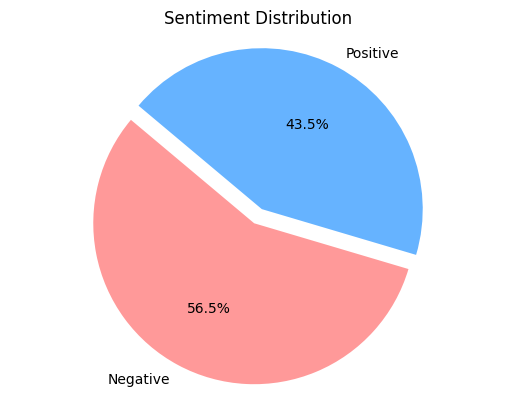

In [ ]:
import matplotlib.pyplot as plt
# Count the number of each sentiment
sentiment_counts = data['sentiment'].value_counts()

# Labels for the sections of our pie chart
labels = ['Negative', 'Positive'] if len(sentiment_counts) == 2 else ['Negative', 'Positive', 'Neutral']

# The values for each section of the pie chart
sizes = sentiment_counts.values

# The colors of each section of the pie chart
colors = ['#ff9999','#66b3ff','#99ff99']

# Exploding the 1st slice (i.e. 'Positive')
explode = (0.1, 0) if len(sentiment_counts) == 2 else (0.1, 0, 0)

# Creating the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

plt.title("Sentiment Distribution")
plt.show()

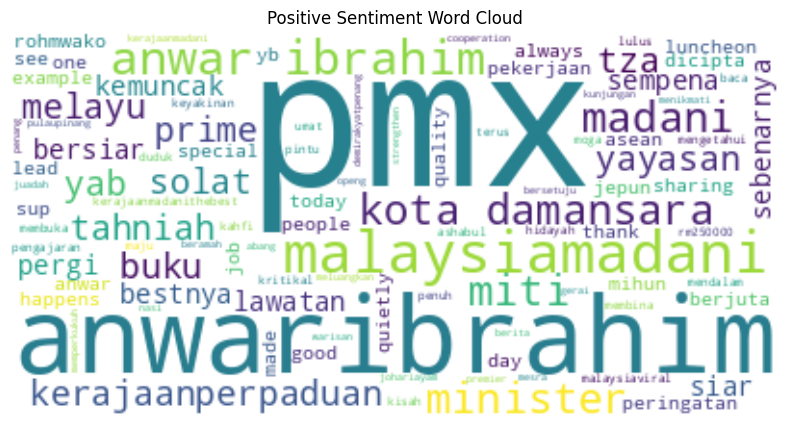

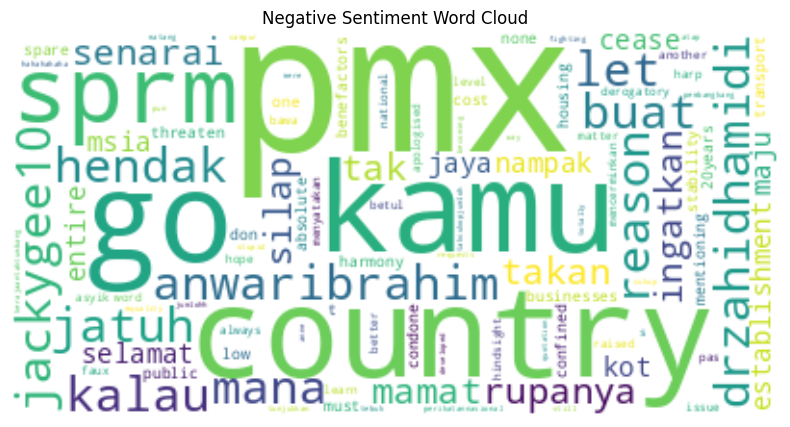

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to preprocess all tweets in a dataset
def preprocess_tweets(tweets):
    preprocessed_tweets = [preprocess_for_v1(tweet) for tweet in tweets]
    return " ".join(preprocessed_tweets)

# Separate tweets based on sentiment
positive_tweets = data[data['sentiment'] == 1]['text']
negative_tweets = data[data['sentiment'] == 0]['text']

# Preprocess the tweets
positive_text = preprocess_tweets(positive_tweets)
negative_text = preprocess_tweets(negative_tweets)

# Create and generate a word cloud image for positive sentiment
positive_wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(positive_text)

# Display the generated image for positive sentiment
plt.figure(figsize=(10,5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Sentiment Word Cloud')
plt.show()

print("\n")
print("\n")
print("\n")
# Create and generate a word cloud image for negative sentiment
negative_wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(negative_text)

# Display the generated image for negative sentiment
plt.figure(figsize=(10,5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Sentiment Word Cloud')
plt.show()